# Training

In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.vae import VAE
from src.starcattovae.nn.cvae import CVAE
from src.starcattovae.nn.vae_cnn import VAECNN

/Users/tarineccleston/Desktop/starccato/starccato-vae/src/starcattovae/training/data.py:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


In [5]:
from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_individual_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs
from src.starcattovae.plotting import plot_signal_distribution

In [6]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [7]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 512

x_length = 256
hidden_dim = 512
latent_dim = 128
num_channels = 1
lr = 1e-3

Using device: mps


## Load Training Data

In [8]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True)
validation_dataset = Data(indices=validation_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [9]:
train_dataset.summary()
validation_dataset.summary()

2024-11-24 00:38:00.762 | INFO     | src.starcattovae.training.data:summary:98 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset max parameter value: 0.215476612137
Signal Dataset shape: (256, 1515)

2024-11-24 00:38:00.763 | INFO     | src.starcattovae.training.data:summary:98 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset max parameter value: 0.210273745719
Signal Dataset shape: (256, 169)



In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load VAE

In [11]:
model = VAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, DEVICE=DEVICE).to(DEVICE)
model_conditional = CVAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, condition_dim=1, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [12]:
def loss_function(x, x_hat, mean, log_var):
    # sse loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss *= 1 * x.shape[1]
    
    # KL Divergence loss
    kld_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # total loss
    total_loss = reproduction_loss + kld_loss

    return total_loss, reproduction_loss, kld_loss

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

Start training VAE...


Training:   0%|          | 1/512 [00:01<10:18,  1.21s/it]

Epoch 1, Train Loss: 230.3114, Val Loss: 144.0662


Training:   0%|          | 2/512 [00:01<07:40,  1.11it/s]

Epoch 2, Train Loss: 121.7092, Val Loss: 113.2195


Training:   1%|          | 3/512 [00:02<06:46,  1.25it/s]

Epoch 3, Train Loss: 95.6863, Val Loss: 92.1212


Training:   1%|          | 4/512 [00:03<06:16,  1.35it/s]

Epoch 4, Train Loss: 85.4582, Val Loss: 87.3406


Training:   1%|          | 5/512 [00:03<06:02,  1.40it/s]

Epoch 5, Train Loss: 81.6914, Val Loss: 87.1098


Training:   1%|          | 6/512 [00:04<05:49,  1.45it/s]

Epoch 6, Train Loss: 79.5719, Val Loss: 80.7777


Training:   1%|▏         | 7/512 [00:05<05:43,  1.47it/s]

Epoch 7, Train Loss: 74.7131, Val Loss: 77.5714


Training:   2%|▏         | 8/512 [00:05<05:40,  1.48it/s]

Epoch 8, Train Loss: 71.5534, Val Loss: 73.7477


Training:   2%|▏         | 9/512 [00:06<05:34,  1.50it/s]

Epoch 9, Train Loss: 69.1215, Val Loss: 70.0575


Training:   2%|▏         | 9/512 [00:07<05:34,  1.50it/s]

Epoch 10, Train Loss: 65.5295, Val Loss: 67.2491


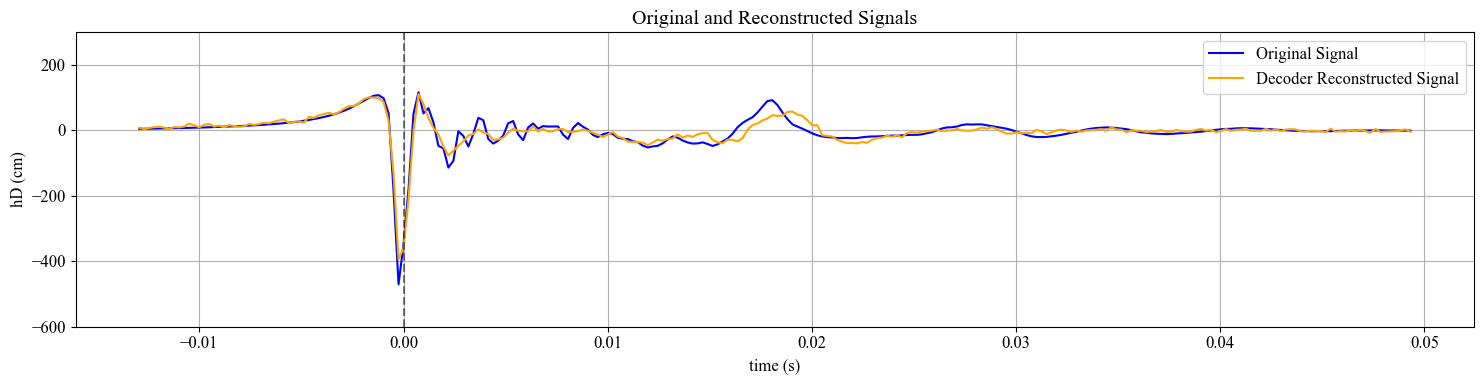

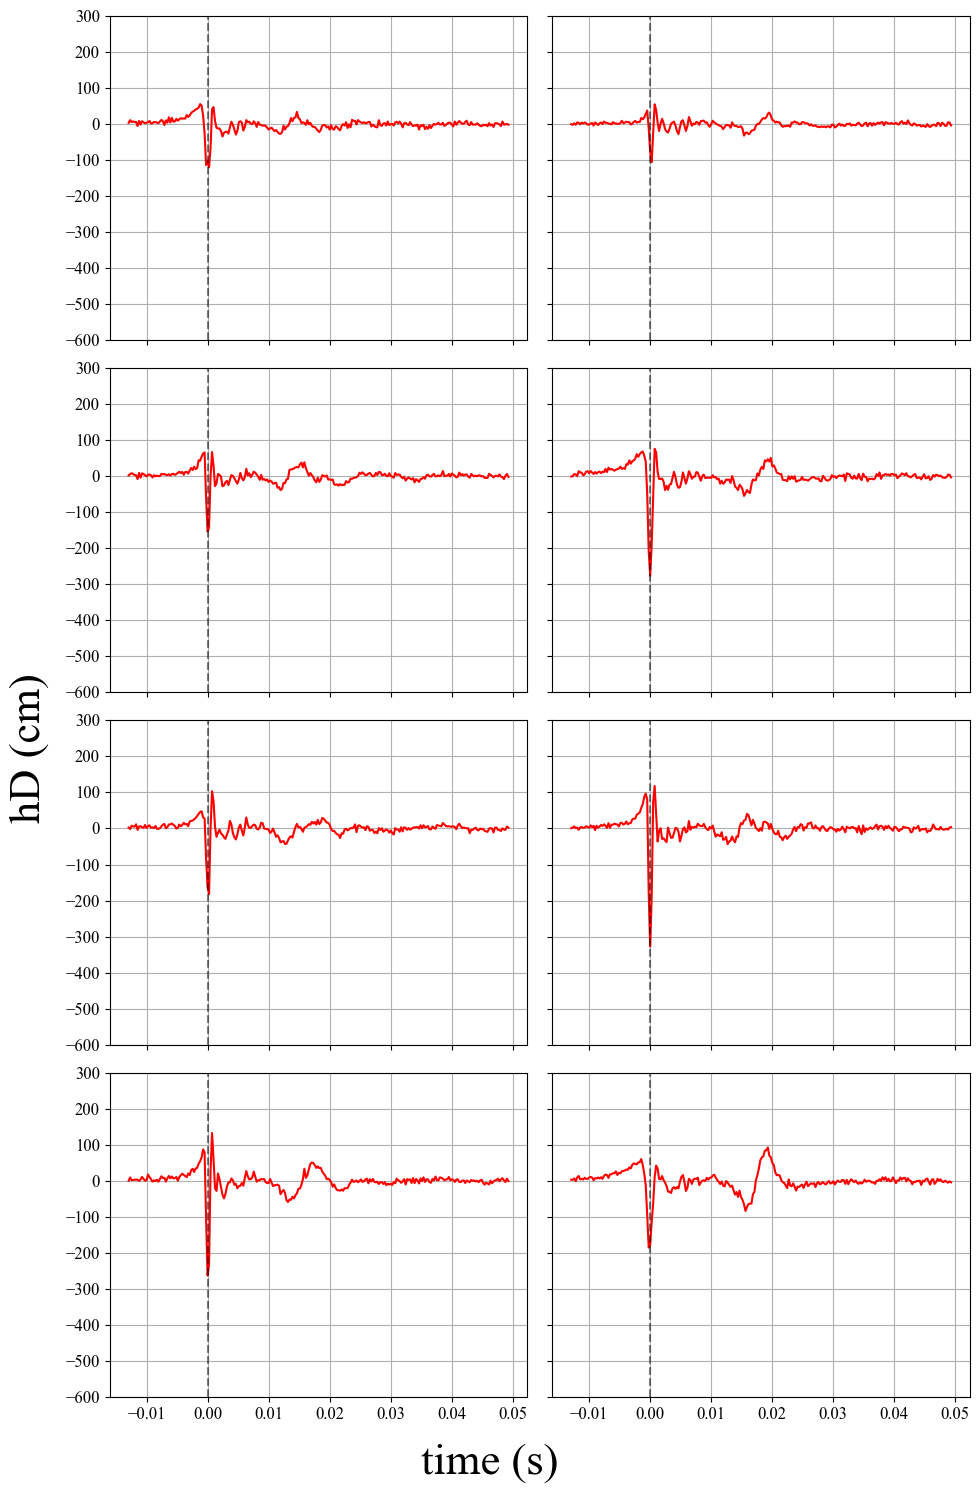

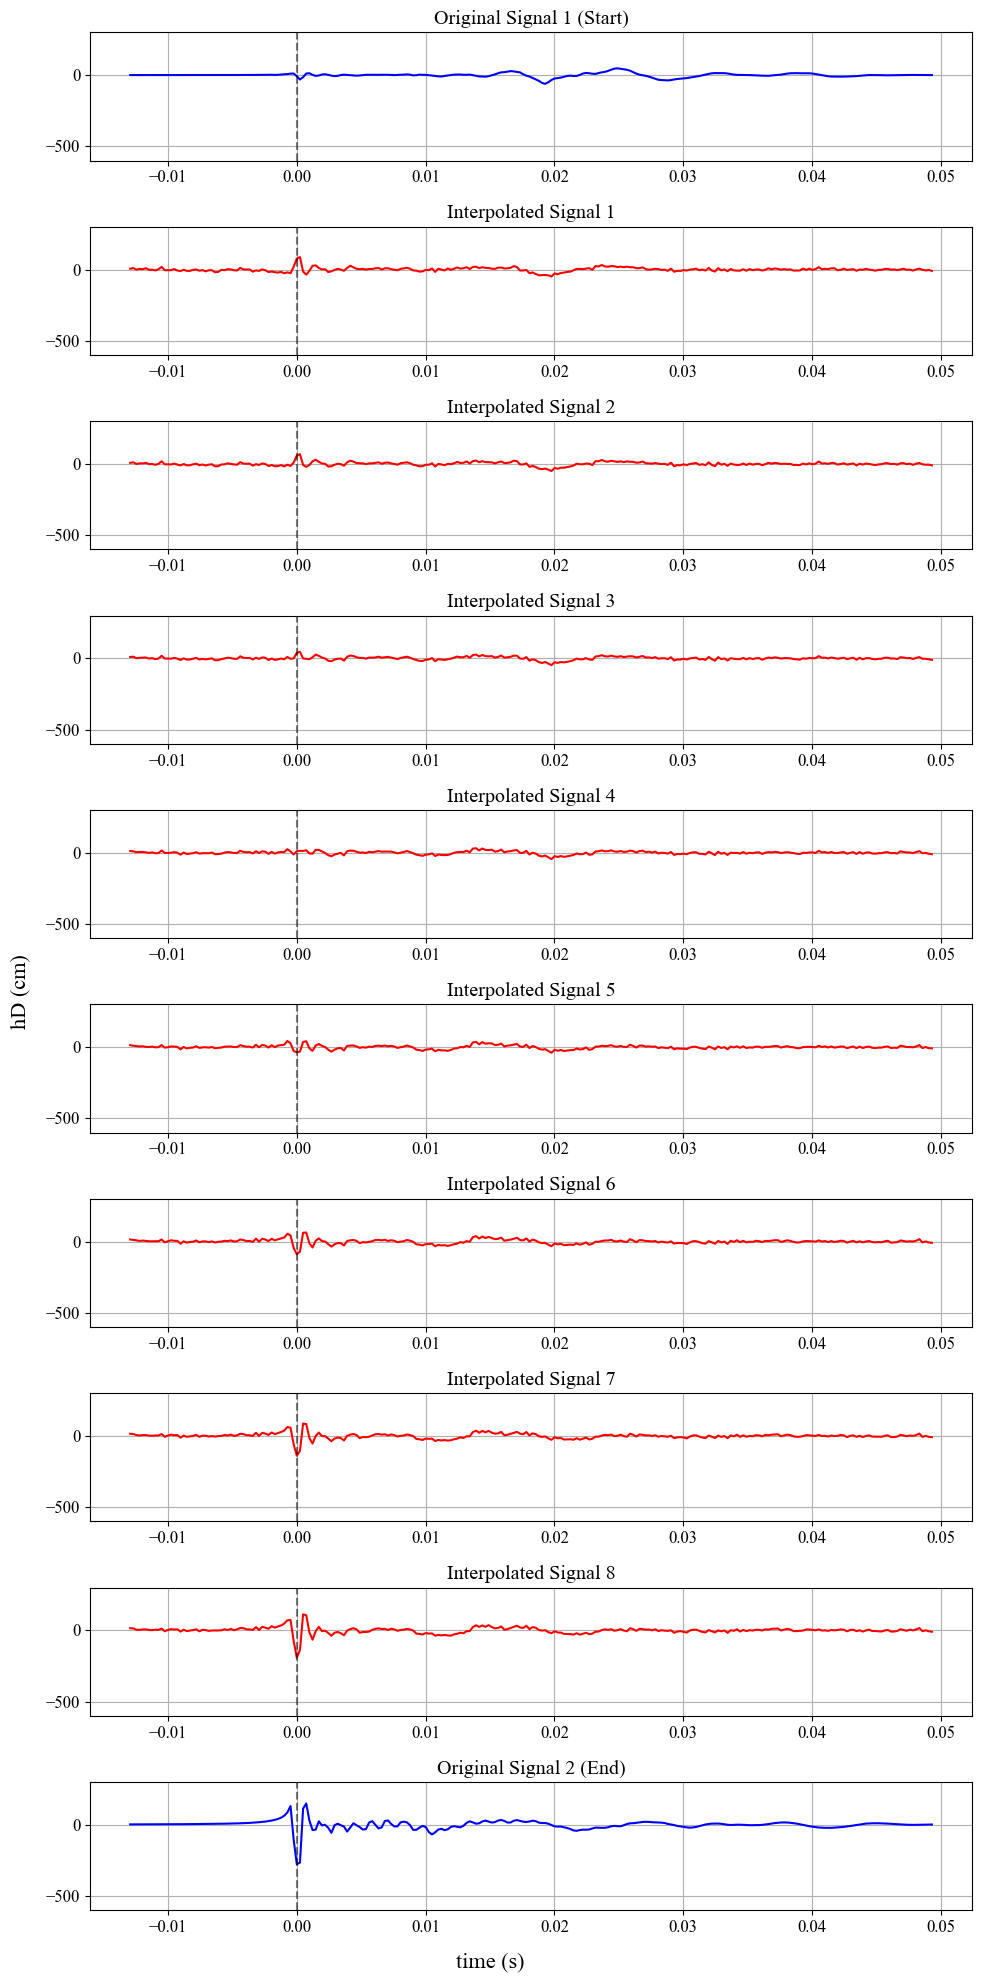

Training:   2%|▏         | 11/512 [00:09<08:13,  1.01it/s]

Epoch 11, Train Loss: 63.0904, Val Loss: 67.0760


Training:   2%|▏         | 12/512 [00:09<07:24,  1.13it/s]

Epoch 12, Train Loss: 61.9410, Val Loss: 62.7020


Training:   2%|▏         | 12/512 [00:10<07:17,  1.14it/s]


KeyboardInterrupt: 

In [13]:
print("Start training VAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)

# validation data for validation
validation_data = []
for x_validation, y_validation in validation_dataloader:
    validation_data.append(x_validation.to(DEVICE))
validation_data = torch.cat(validation_data, dim=0)

for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, (x, y) in enumerate(train_dataloader, 0):
        model.train()
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        model.eval()
        with torch.no_grad():
            x_validation = validation_data
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model(x_validation)
            total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_kld_loss = overall_kld_loss / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_kld_losses_validation.append(avg_kld_loss_validation)

    tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = model.decoder(noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        
        plot_latent_morphs(model, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

print("Training finished!")
model.eval()

#### CVAE Training

In [ ]:
print("Start training CVAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)
condition_noise = torch.tensor([0.1] * batch_size, dtype=torch.float32).to(DEVICE).unsqueeze(1)

# validation data for validation
validation_data = []
validation_conditions = []
for x_validation, y_validation in validation_dataloader:
    validation_data.append(x_validation.to(torch.float32).to(DEVICE))
    validation_conditions.append(y_validation.to(torch.float32).to(DEVICE).unsqueeze(1))
validation_data = torch.cat(validation_data, dim=0)
validation_conditions = torch.cat(validation_conditions, dim=0)

for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, (x, y) in enumerate(train_dataloader, 0):
        model_conditional.train()
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)
        y = y.to(torch.float32).to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()

        x_hat, mean, log_var = model_conditional(x, y)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        model_conditional.eval()
        with torch.no_grad():
            x_validation = validation_data
            y_validation = validation_conditions
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model_conditional(x_validation, y_validation)
            total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_kld_loss = overall_kld_loss / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_kld_losses_validation.append(avg_kld_loss_validation)

    tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = model_conditional.decoder(noise, condition_noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        condition_1 = y[idx1].to(DEVICE)
        condition_2 = y[idx2].to(DEVICE)
        
        # plot_latent_morphs(model_conditional, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

print("Training finished!")
model_conditional.eval()

Start training CVAE...


Training:   0%|          | 0/512 [00:00<?, ?it/s]

tensor([[0.3298],
        [0.5419],
        [0.4893],
        [0.9448],
        [0.4731],
        [0.9790],
        [0.0592],
        [0.0322],
        [0.1671],
        [0.8735],
        [0.2064],
        [0.8090],
        [0.5229],
        [0.8490],
        [0.0030],
        [0.5393],
        [0.1011],
        [0.8011],
        [0.1406],
        [0.7903],
        [0.0193],
        [0.5986],
        [0.0030],
        [0.7926],
        [0.0421],
        [0.0596],
        [0.2778],
        [0.9160],
        [0.3352],
        [0.0579],
        [0.0432],
        [0.0030]], device='mps:0')
tensor([[0.1708],
        [0.0915],
        [0.0114],
        [0.9538],
        [0.6123],
        [0.8780],
        [0.3224],
        [0.9457],
        [0.0017],
        [0.0342],
        [0.4013],
        [0.0066],
        [0.5992],
        [0.2669],
        [0.1264],
        [0.2264],
        [0.0582],
        [0.8672],
        [0.2404],
        [0.3527],
        [0.3020],
        [0.1267],
        [0.

Training:   0%|          | 1/512 [00:01<09:59,  1.17s/it]

tensor([[0.8694],
        [0.1261],
        [0.3564],
        [0.1024],
        [0.5547],
        [0.0408],
        [0.4132],
        [0.0683],
        [0.1303],
        [0.3489],
        [0.0185]], device='mps:0')
Epoch 1, Train Loss: 955.5387, Val Loss: 947.7433
tensor([[0.2136],
        [0.0018],
        [0.8799],
        [0.0029],
        [0.1598],
        [0.0069],
        [0.0812],
        [0.7897],
        [0.7337],
        [0.7761],
        [0.4349],
        [0.3723],
        [0.3875],
        [0.4900],
        [0.7988],
        [0.1259],
        [0.4568],
        [0.4881],
        [0.3442],
        [0.0798],
        [0.3830],
        [0.9034],
        [0.2397],
        [0.3946],
        [0.0029],
        [0.2205],
        [0.7962],
        [0.6853],
        [0.0036],
        [0.9345],
        [0.4644],
        [0.9098]], device='mps:0')
tensor([[0.0030],
        [0.5229],
        [0.1792],
        [0.1221],
        [0.4260],
        [0.0825],
        [0.0148],
        [0.4245]

Training:   0%|          | 2/512 [00:02<08:54,  1.05s/it]

tensor([[0.4075],
        [0.1741],
        [0.3443],
        [0.2257],
        [0.2258],
        [0.3382],
        [0.7328],
        [0.1068],
        [0.4272],
        [0.1247],
        [0.8886]], device='mps:0')
Epoch 2, Train Loss: 956.7348, Val Loss: 959.7044
tensor([[0.7903],
        [0.2722],
        [0.0030],
        [0.5679],
        [0.0934],
        [0.8304],
        [0.9464],
        [0.5584],
        [0.4161],
        [0.2234],
        [0.3867],
        [0.0915],
        [0.0152],
        [0.2533],
        [0.1640],
        [0.0145],
        [0.1248],
        [0.6123],
        [0.0886],
        [0.4678],
        [0.9701],
        [0.1233],
        [0.1348],
        [0.4425],
        [0.0281],
        [0.2754],
        [0.3295],
        [0.9248],
        [0.0556],
        [0.0785],
        [0.3963],
        [0.5384]], device='mps:0')
tensor([[0.8339],
        [0.0824],
        [0.0581],
        [0.6583],
        [0.1658],
        [0.0261],
        [0.8893],
        [0.4451]

Training:   1%|          | 3/512 [00:03<08:46,  1.04s/it]

tensor([[0.0604],
        [0.4909],
        [0.8495],
        [0.8886],
        [0.7926],
        [0.2847],
        [0.9063],
        [0.6888],
        [0.3717],
        [0.0069],
        [0.6853]], device='mps:0')
Epoch 3, Train Loss: 954.6168, Val Loss: 953.8793
tensor([[0.3443],
        [0.4507],
        [0.7876],
        [0.4621],
        [0.7669],
        [0.1705],
        [0.9543],
        [0.7145],
        [0.4326],
        [0.5594],
        [0.0017],
        [0.0150],
        [0.6768],
        [0.8339],
        [0.0262],
        [0.8223],
        [0.4073],
        [0.0790],
        [0.8854],
        [0.2132],
        [0.8158],
        [0.0466],
        [0.0113],
        [0.2120],
        [0.3771],
        [0.3876],
        [0.3200],
        [0.1267],
        [0.9409],
        [0.9063],
        [0.1604],
        [0.3318]], device='mps:0')
tensor([[0.3256],
        [0.5320],
        [0.3037],
        [0.7903],
        [0.1347],
        [0.0432],
        [0.1637],
        [0.1230]

Training:   1%|          | 4/512 [00:04<08:34,  1.01s/it]

tensor([[0.2257],
        [0.6693],
        [0.2508],
        [0.5467],
        [1.0000],
        [0.0197],
        [0.2665],
        [0.0811],
        [0.0322],
        [0.0273],
        [0.0552],
        [0.2901],
        [0.6629],
        [0.2175],
        [0.0030],
        [0.7987],
        [0.0460],
        [0.1778],
        [0.2542],
        [0.6594],
        [0.4907],
        [0.2211],
        [0.7285],
        [0.4272],
        [0.4133],
        [0.9148],
        [0.5369],
        [0.1248],
        [0.1760],
        [0.0054],
        [0.1288],
        [0.1037]], device='mps:0')
tensor([[0.0193],
        [0.0797],
        [0.1806],
        [0.7669],
        [0.0436],
        [0.2215],
        [0.6699],
        [0.0590],
        [0.0564],
        [0.0829],
        [0.4127],
        [0.8610],
        [0.2731],
        [0.1098],
        [0.1235],
        [0.0583],
        [0.1948],
        [0.0068],
        [0.6429],
        [0.0343],
        [0.2179],
        [0.1598],
        [0.

Training:   1%|          | 5/512 [00:05<08:36,  1.02s/it]

tensor([[0.9513],
        [0.3331],
        [0.3422],
        [0.0466],
        [0.2970],
        [0.0071],
        [0.0016],
        [0.7558],
        [0.2768],
        [0.2234],
        [0.4892],
        [0.5235],
        [0.3948],
        [0.1120],
        [0.4731],
        [0.4468],
        [0.0155],
        [0.9772],
        [0.9276],
        [0.2657],
        [0.7085],
        [0.0309],
        [0.9546],
        [0.5456],
        [0.5285],
        [0.6333],
        [0.0834],
        [0.0261],
        [0.9404],
        [0.3302],
        [0.4846],
        [0.1012]], device='mps:0')
tensor([[0.2258],
        [0.0989],
        [0.7790],
        [0.8134],
        [0.0562],
        [0.4881],
        [0.4241],
        [0.2404],
        [0.9205],
        [0.7545],
        [0.9536],
        [0.3697],
        [0.9675],
        [0.8547],
        [0.0261],
        [0.0190],
        [0.7080],
        [0.0208],
        [0.3334],
        [0.0036],
        [0.0147],
        [0.1892],
        [0.

Training:   1%|          | 6/512 [00:06<08:41,  1.03s/it]

Epoch 6, Train Loss: 949.1687, Val Loss: 957.9684
tensor([[0.8735],
        [0.4326],
        [0.0268],
        [0.0417],
        [0.7431],
        [0.2180],
        [0.2199],
        [0.2940],
        [0.1729],
        [0.5395],
        [0.2354],
        [0.0184],
        [0.0475],
        [0.0038],
        [0.1362],
        [0.1760],
        [0.0037],
        [0.3013],
        [0.3998],
        [0.0053],
        [0.1273],
        [0.0207],
        [0.8301],
        [0.8133],
        [0.0051],
        [0.5481],
        [0.0440],
        [0.4273],
        [0.0148],
        [0.6406],
        [0.6656],
        [0.5235]], device='mps:0')
tensor([[0.1574],
        [0.9299],
        [0.0067],
        [0.2897],
        [0.1514],
        [0.0846],
        [0.6323],
        [0.3406],
        [0.1792],
        [0.0896],
        [0.0052],
        [0.0579],
        [0.1644],
        [0.3669],
        [0.0413],
        [0.1726],
        [0.1013],
        [0.1708],
        [0.4772],
        [0.8259

Training:   1%|▏         | 7/512 [00:07<08:37,  1.02s/it]

tensor([[0.8362],
        [0.0462],
        [0.6067],
        [0.4114],
        [0.0831],
        [0.2258],
        [0.7375],
        [0.4614],
        [0.3867],
        [0.8490],
        [0.5652],
        [0.3277],
        [0.9701],
        [0.1274],
        [0.4156],
        [0.0152],
        [0.1172],
        [0.2938],
        [0.4058],
        [0.0737],
        [0.1037],
        [0.4204],
        [0.0826],
        [0.0582],
        [0.1040],
        [0.0071],
        [0.4139],
        [0.1201],
        [0.0213],
        [0.4140],
        [0.7235],
        [0.0735]], device='mps:0')
tensor([[0.9254],
        [0.9820],
        [0.7990],
        [0.2712],
        [0.8139],
        [0.1138],
        [0.6768],
        [0.1381],
        [0.5144],
        [0.3257],
        [0.7876],
        [0.6610],
        [0.0068],
        [0.0117],
        [0.0065],
        [0.2677],
        [0.3442],
        [0.7878],
        [0.2213],
        [0.5235],
        [0.0460],
        [0.4678],
        [0.

Training:   2%|▏         | 8/512 [00:08<08:26,  1.01s/it]

tensor([[0.2369],
        [0.4248],
        [0.8893],
        [0.0812],
        [0.7830],
        [0.8350],
        [0.2170],
        [0.0417],
        [0.5347],
        [0.0198],
        [0.0150],
        [0.1143],
        [0.0686],
        [0.9536],
        [0.4821],
        [0.0779],
        [0.0272],
        [0.7903],
        [0.8495],
        [0.1969],
        [0.0255],
        [0.1702],
        [0.0068],
        [0.1373],
        [0.9820],
        [0.3200],
        [0.2732],
        [0.3422],
        [0.0047],
        [0.8174],
        [0.2543],
        [0.5462]], device='mps:0')
tensor([[0.8886],
        [0.1013],
        [0.4162],
        [0.3440],
        [0.0434],
        [0.2209],
        [0.1233],
        [0.8623],
        [0.6629],
        [0.3295],
        [0.7786],
        [0.4327],
        [0.1048],
        [0.1227],
        [0.1757],
        [0.8032],
        [0.1709],
        [0.2503],
        [0.0455],
        [0.0185],
        [0.3418],
        [0.1024],
        [0.

Training:   2%|▏         | 9/512 [00:09<08:37,  1.03s/it]

tensor([[0.0155],
        [0.7719],
        [0.1648],
        [0.0266],
        [0.4772],
        [0.2274],
        [0.3697],
        [0.1293],
        [0.1037],
        [0.5855],
        [0.0212],
        [0.3318],
        [0.0906],
        [0.8180],
        [0.0582],
        [0.1722],
        [0.2209],
        [0.0804],
        [0.1131],
        [0.1729],
        [0.8811],
        [0.2728],
        [0.3408],
        [0.2161],
        [0.4677],
        [0.0071],
        [0.1048],
        [0.1381],
        [0.1354],
        [0.1026],
        [0.0580],
        [0.2943]], device='mps:0')
tensor([[0.3350],
        [0.0048],
        [0.0419],
        [0.6624],
        [0.7962],
        [0.5227],
        [0.0150],
        [0.0119],
        [0.9546],
        [0.6199],
        [0.8678],
        [0.0067],
        [0.0048],
        [0.7080],
        [0.8339],
        [0.0149],
        [0.0724],
        [0.0419],
        [0.7771],
        [0.1003],
        [0.2277],
        [0.0910],
        [0.

### Training and Validation Loss

In [ ]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

In [ ]:
plot_individual_loss(avg_total_losses, avg_reproduction_losses, avg_kld_losses)

### Generated XXXXX Signals

In [ ]:
number_of_signals = 10000
noise = torch.randn(number_of_signals, latent_dim).to(DEVICE)

start_time = time.time()
with torch.no_grad():
    generated_signals = model.decoder(noise).cpu().detach().numpy()
end_time = time.time()

execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

In [ ]:
generated_signals_transpose = np.empty((x_length, 0))

for i in range(number_of_signals):
    y = generated_signals[i, :].flatten()
    y = y * train_dataset.max_value
    y = y.reshape(-1, 1)
    
    generated_signals_transpose = np.concatenate((generated_signals_transpose, y), axis=1)

### Plot Generated Distribution

In [ ]:
plot_signal_distribution(generated_signals_transpose, generated=True)

### Morph Animation

In [ ]:
def animate_latent_morphs(
    model: VAE, 
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        interpolated_latents = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

    fig, ax = plt.subplots(figsize=(10, 5))

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax.plot([], [], color="red")
    ax.set_xlim(min(x_vals), max(x_vals))
    ax.set_ylim(-600, 300)
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax.grid(True)
    ax.set_xlabel('time (s)', fontsize=16)
    ax.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        ax.set_title(f"Interpolated Signal {frame + 1}")
        return line,

    ani = animation.FuncAnimation(fig, update, frames=range(steps), init_func=init, blit=True, interval=interval)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, steps=100, interval=200, save_path="morph_animation.gif")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def animate_latent_morphs(
    model,  # Assuming model is a VAE instance
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    train_dataset,
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        # Forward and backward interpolation
        forward_interpolated = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        backward_interpolated = [mean_2 * (1 - alpha) + mean_1 * alpha for alpha in np.linspace(0, 1, steps)]
        interpolated_latents = forward_interpolated + backward_interpolated
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

        # Compute the posterior distribution
        all_means = []
        for data in train_dataset:
            data = torch.tensor(data).to(model.DEVICE)
            mean, _ = model.encoder(data)
            all_means.append(mean.cpu().numpy())
        all_means = np.concatenate(all_means, axis=0)

    fig = plt.figure(figsize=(10, 17))  # Adjust the figure size for vertical stacking

    # Create 3D plot for latent space
    ax_latent = fig.add_subplot(211, projection='3d')  # First plot (top) in vertical layout
    ax_latent.scatter(all_means[:, 0], all_means[:, 1], all_means[:, 2], color='gray', alpha=0.2, label='Posterior Distribution')
    ax_latent.scatter(mean_1[0].cpu().numpy(), mean_1[1].cpu().numpy(), mean_1[2].cpu().numpy(), color='blue', s=50, label='Signal 1')
    ax_latent.scatter(mean_2[0].cpu().numpy(), mean_2[1].cpu().numpy(), mean_2[2].cpu().numpy(), color='green', s=50, label='Signal 2')
    ax_latent.plot([mean_1[0].cpu().numpy(), mean_2[0].cpu().numpy()],
                   [mean_1[1].cpu().numpy(), mean_2[1].cpu().numpy()],
                   [mean_1[2].cpu().numpy(), mean_2[2].cpu().numpy()], color='red', linestyle='--', label='Interpolation Path', linewidth=2)
    moving_point, = ax_latent.plot([], [], [], 'ro', markersize=7, label='Interpolated Point')
    # ax_latent.set_title('Latent Space Interpolation')
    ax_latent.set_xlabel('Latent Dim 1')
    ax_latent.set_ylabel('Latent Dim 2')
    ax_latent.set_zlabel('Latent Dim 3')
    # ax_latent.legend()

    # Create plot for signal morphing
    ax_signal = fig.add_subplot(212)  # Second plot (bottom) in vertical layout

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax_signal.plot([], [], color="red")
    ax_signal.set_xlim(min(x_vals), max(x_vals))
    ax_signal.set_ylim(-600, 300)
    ax_signal.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax_signal.grid(True)
    ax_signal.set_xlabel('time (s)', fontsize=16)
    ax_signal.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        moving_point.set_data([], [])
        moving_point.set_3d_properties([])
        return line, moving_point

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        # ax_signal.set_title(f"Interpolated Signal {frame + 1}")

        # Update the moving point in the latent space
        latent_point = interpolated_latents[frame].cpu().numpy()
        moving_point.set_data(latent_point[0], latent_point[1])
        moving_point.set_3d_properties(latent_point[2])
        return line, moving_point

    ani = animation.FuncAnimation(fig, update, frames=len(interpolated_latents), init_func=init, blit=True, interval=interval, repeat=True)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path="morph_animation.gif")
